<a href="https://colab.research.google.com/github/hoihui/tutorial/blob/master/ImageTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# !pip3 install -U torch torchvision
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, cuda

('1.1.0', False)

In [3]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

     |████████████████████████████████| 332.1MB 57kB/s 
     |████████████████████████████████| 419kB 51.8MB/s 
     |████████████████████████████████| 61kB 22.0MB/s 
     |████████████████████████████████| 3.0MB 54.5MB/s 


'2.0.0-alpha0'

[Ref](https://towardsdatascience.com/cyclegans-and-pix2pix-5e6a5f0159c4)

# Pix2Pix on building facades w/ tensorflow

https://www.tensorflow.org/alpha/tutorials/generative/pix2pix

* Use a conditional GAN (cGAN) to learn a mapping from an input image to an output image.
* The training set must have a tight one-to-one correspondence between input and output. (paired)

## Data

In [0]:
IMG_WIDTH = IMG_HEIGHT = 256
BATCH_SIZE = 1
BUFFER_SIZE = 400

In [0]:
import os, tempfile, urllib, tarfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz',
                           'facades.tar.gz')
tarfile.open('facades.tar.gz','r:gz').extractall()

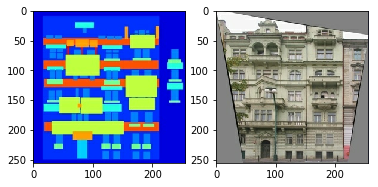

In [6]:
image = tf.image.decode_jpeg(tf.io.read_file('facades/train/100.jpg'))
input_img = tf.cast(image[:,IMG_WIDTH:,:], tf.float32)   # the image is juxtapose [real,input(facades)]
real_img = tf.cast(image[:,:IMG_WIDTH,:], tf.float32)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(input_img/255.0)
ax2.imshow(real_img/255.0)

### Loader

In [0]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    
    real_image =  tf.cast(image[:, :IMG_WIDTH, :], tf.float32)
    input_image = tf.cast(image[:, IMG_WIDTH:, :], tf.float32)
    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
                      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:   #(randomly)
        input_image = tf.image.flip_left_right(input_image)
        real_image  = tf.image.flip_left_right(real_image)
    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [0]:
train_dataset = tf.data.Dataset.list_files('facades/train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files('facades/test/*.jpg')
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

## Model

### Generator

* Modified U-Net <img src="https://cdn-images-1.medium.com/max/1600/1*kpWvVdQOmbMuX2ls-d78TA.png" width="500px">
* Encoder (downsampler) block: (Conv -> Batchnorm -> Leaky ReLU)
* Decoder (upsampler) block: (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
* Skip connections

In [0]:
initializer = tf.random_normal_initializer(0., 0.02)
    
def downsampler(filters, size=4, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add( tf.keras.layers.Conv2D(filters, size, strides=2, #strides=2 => downsamples by 0.5
                                       padding='same',
                                       kernel_initializer=initializer,
                                       use_bias=False))
    if apply_batchnorm:  result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsampler(filters, size=4, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose( filters, size, strides=2,
                                                padding='same',
                                                kernel_initializer=initializer,
                                                use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout: result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [13]:
down_stack = [
    downsampler(64, apply_batchnorm=False), # out (batchsize, 128, 128, 64)
    downsampler(128), # (bs, 64, 64, 128)
    downsampler(256), # (bs, 32, 32, 256)
    downsampler(512), # (bs, 16, 16, 512)
    downsampler(512), # (bs, 8, 8, 512)
    downsampler(512), # (bs, 4, 4, 512)
    downsampler(512), # (bs, 2, 2, 512)
    downsampler(512), # (bs, 1, 1, 512)
]
up_stack = [
    upsampler(512, apply_dropout=True), # (bs, 2, 2, 512)
    upsampler(512, apply_dropout=True), # (bs, 4, 4, 512)
    upsampler(512, apply_dropout=True), # (bs, 8, 8, 512)
    upsampler(512), # (bs, 16, 16, 512)
    upsampler(256), # (bs, 32, 32, 256)
    upsampler(128), # (bs, 64, 64, 128)
    upsampler(64),  # (bs, 128, 128, 64)
]
last = tf.keras.layers.Conv2DTranspose( 3, 4,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        activation='tanh') # (bs, 256, 256, 3)
concat = tf.keras.layers.Concatenate()

inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH,3])
x = inputs

skips = []
for down in down_stack:
    x = down(x)
    skips.append(x)

for up, skip in zip(up_stack, skips[-2::-1]):
    x = up(x)
    x = concat([x, skip])


x = last(x)
G = tf.keras.Model(inputs=inputs, outputs=x)
G.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [0]:
gen_output = G(input_img[tf.newaxis,...], training=False)

### Discriminator

* PatchGAN <img src="https://cdn-images-1.medium.com/max/1600/1*-iPXj4C0sCK0UzW1aPzJZg.png" width="600px">
* receives 2 inputs. (concatenated as a simple list)
   - Input image and the target image, which it should classify as real.
   - Input image and the generated image (output of generator), which it should classify as fake.
* each pixel from the 30x30 output corresponds to the believability of a 70x70 patch of the input image

In [0]:
initializer = tf.random_normal_initializer(0., 0.02)

inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
down1 = downsampler(64, apply_batchnorm=False)(x) # (bs, 128, 128, 64)
down2 = downsampler(128)(down1) # (bs, 64, 64, 128)
down3 = downsampler(256)(down2) # (bs, 32, 32, 256)

zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)     # (bs, 34, 34, 256)
conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                              kernel_initializer=initializer,
                              use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

last = tf.keras.layers.Conv2D(1, 4, strides=1,
                              kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

D = tf.keras.Model(inputs=[inp, tar], outputs=last)

In [16]:
gen_output = G(input_img[tf.newaxis,...], training=False)
dis_output = D([input_img[tf.newaxis,...], gen_output])
dis_output.shape # Each 30x30 patch of the output classifies a 70x70 portion of the input image

TensorShape([1, 30, 30, 1])

### Losses and optimizer

4 components of loss (objective is...): 
* optimize D so that D classifies real as real
* optimize D so that D classifies fake as fake
* optimize G so that D classifies fake as real
* optimize G so that output of G matches given target image

In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss   # loss from classifying real as fake or vice versa
    return total_disc_loss

def g_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)  # loss driving fake img to be classified as real by D, and driving fake to true (provided) img
    return total_gen_loss

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Train

### Checkpoint

In [0]:
checkpoint_dir = tempfile.gettempdir()
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(g_optimizer=g_optimizer,
                                 d_optimizer=d_optimizer,
                                 G=G,
                                 D=D)

### Visualization tool

In [0]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

### Step

In [0]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        g_output = G(input_image, training=True)

        d_real_output = D([input_image, target], training=True)
        d_generated_output = D([input_image, g_output], training=True)

        g_loss_ = g_loss(d_generated_output, gen_output, target)
        d_loss_ = d_loss(d_real_output, d_generated_output)

    g_grad = g_tape.gradient(g_loss_, G.trainable_variables)
    d_grad = d_tape.gradient(d_loss_, D.trainable_variables)

    g_optimizer.apply_gradients(zip(g_grad, G.trainable_variables))
    d_optimizer.apply_gradients(zip(d_grad, D.trainable_variables))

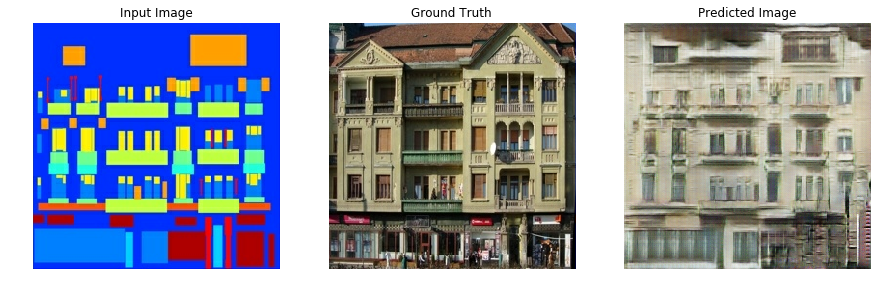

In [24]:
from IPython.display import clear_output
def train(dataset, epochs):
    for _ in range(epochs):
        for input_image, target in dataset:
            train_step(input_image, target)

        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(G, inp, tar)

        checkpoint.save(file_prefix = checkpoint_prefix)

train(train_dataset, 100)

### Test

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
for inp, tar in test_dataset.take(10):
    generate_images(G, inp, tar)

# CycleGAN on Yosemite's summer/winter w/ torch

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/cycle-gan/CycleGAN_Solution.ipynb
* Given two sets of images X & Y
* Transform an image from X so that it looks as if it belongs in Y
* No strict 1-to-1 correspondence between X & Y. e.g. X = photos in summer, Y = photos in winter, unpaired (i.e. unsupervised)

In [4]:
import torch, torchvision

## Data

In [2]:
import os, tempfile, urllib, zipfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip','yosemite.zip')
zipfile.ZipFile('yosemite.zip').extractall()
# folder structure: ./summer2winter_yosemite/(summer|test_summer|winter|test_winter)/(summer|winter)

In [7]:
def get_data_loader(image_type):
    
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize(128), # resize to 128*128
                                                torchvision.transforms.ToTensor()])

    train_path = f'./summer2winter_yosemite/{image_type}'
    test_path = f'./summer2winter_yosemite/test_{image_type}'

    train_dataset = torchvision.datasets.ImageFolder(train_path, transform)
    test_dataset = torchvision.datasets.ImageFolder(test_path, transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

    return train_loader, test_loader

dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

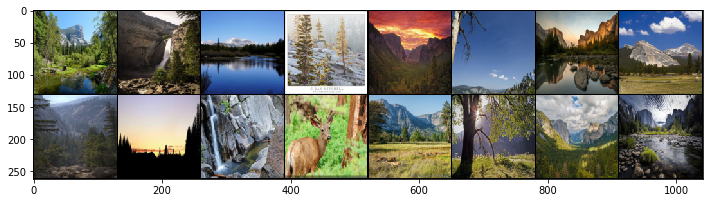

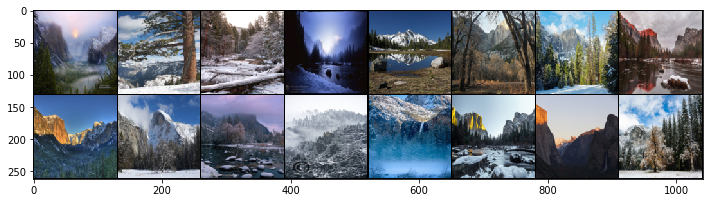

In [16]:
# samples
for loader in [dataloader_X,dataloader_Y]:
    images, _ = next(iter(loader))
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(np.transpose(torchvision.utils.make_grid(images),(1,2,0)))

In [25]:
# scale the img range from (0,1) to (-1,1)
scale = lambda x: 2*x-1
scale(images).shape

torch.Size([16, 3, 128, 128])

## Model

Two generators (`G_XY`, `G_YX` respectively for translating from X to Y and from Y to X) and two discriminators (`D_Y`, `D_X` respectively for outputs from `G_XY` and `G_YX`)

### Discriminators

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/cycle-gan/notebook_images/discriminator_layers.png" width="800px"/>

In [37]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):    
    layers = []
    layers += nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                        kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
    if batch_norm: layers+=nn.BatchNorm2d(out_channels),
        
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        
        # first&last layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, batch_norm=False) # in (3, 128, 128), out (64, 64, 64)
        self.conv2 = conv(conv_dim,   conv_dim*2)        # (128, 32, 32)
        self.conv3 = conv(conv_dim*2, conv_dim*4)        # (256, 16, 16)
        self.conv4 = conv(conv_dim*4, conv_dim*8)        # (512, 8, 8)        
        self.conv5 = conv(conv_dim*8, 1, stride=1, batch_norm=False) # (1, 7, 7)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.conv5(out)
        return out
    
D_X = Discriminator().to(device)
D_Y = Discriminator().to(device)
D_X(torch.rand((42,3,128,128))).shape

torch.Size([42, 1, 7, 7])

### Generators

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/cycle-gan/notebook_images/cyclegan_generator_ex.png" width="1000px"/>

* `Residual block`s connects the output of one layer with the input of an earlier layer, to alleviate vanishing or exploding gradients
* learn so-called residual functions as they are applied to layer inputs <img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/cycle-gan/notebook_images/resnet_block.png" width="250px"/>
* instead of optimizing the weights of NN, $M$, such that $M(x)\sim y$, optimize such that $M(x)+x\sim y$, that is, add the input to network output before comparing with $y$.
* allows a model to learn an effective transformation from one domain to another

In [38]:
class ResidualBlock(nn.Module):
    """Adds an input x to a convolutional layer (applied to x) with the same size input and output """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True) # input.shape=output.shape        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        m_x = F.relu(self.conv_layer1(x))
        m_x = self.conv_layer2(m_x)
        return x + m_x
    
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    layers += nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
    if batch_norm: layers += nn.BatchNorm2d(out_channels),
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(Generator, self).__init__()

        self.conv1 = conv(3, conv_dim)            # in (3,128,128) out (64,64,64)
        self.conv2 = conv(conv_dim, conv_dim*2)   # (128, 32, 32)
        self.conv3 = conv(conv_dim*2, conv_dim*4) # (256, 16, 16)
           
        self.res_blocks = nn.Sequential(*[ResidualBlock(conv_dim*4)
                                          for _ in range(n_res_blocks)]) # (256, 16, 16)
        
        self.deconv1 = deconv(conv_dim*4, conv_dim*2) # (128, 32, 32)
        self.deconv2 = deconv(conv_dim*2, conv_dim) # (64, 64, 64)       
        self.deconv3 = deconv(conv_dim, 3, batch_norm=False) # (3,128,128); no batchnorm on last layer

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))        
        out = torch.tanh(self.deconv3(out)) # tanh for the last

        return out

G_XY = Generator().to(device)
G_YX = Generator().to(device)
D_X(G_YX(torch.rand((42,3,128,128)))).shape

torch.Size([42, 1, 7, 7])

### Losses and optimizers

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/cycle-gan/notebook_images/CycleGAN_loss.png" width="500px">

* Use least squares for D to [mitigate vanishing gradients problem](https://arxiv.org/pdf/1611.04076.pdf)
* Components of loss (objective is...):
  - `D_X` & `D_Y` correctly classifying real as real & fake as fake (eg. `loss_real = torch.mean((D_X(x)-1)**1)`)
  - `G_XY` & `G_YX` makes `D_X` & `D_Y` to classify fake as real
  - `G_YX(G_XY(x))` be as close to `x` as possible ("cycle_consistency_loss")

In [41]:
import torch.optim as optim
lr=0.0002
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XY.parameters()) + list(G_YX.parameters())
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

In [53]:
LAMBDA = 10  # consistency loss

def d_loss(D_real, D_fake):
    real_loss = torch.mean((D_real-1)**2)
    fake_loss = torch.mean(D_fake**2)
    return real_loss+fake_loss # loss from classifying real as fake or vice versa

def g_loss(D_fake, reconstructed, original):
    fake_loss = torch.mean((D_fake-1)**2) # goal is to make D classify fake as real
    recon_loss = torch.mean(torch.abs(reconstructed - original)) # goal is to have reconstructed as close to original as possible
    return fake_loss + LAMBDA*recon_loss

## Train

In [54]:
def train_step(images_X, images_Y):
    images_X = scale(images_X).to(device)
    images_Y = scale(images_Y).to(device)
    
    ##################D_X####################
    d_x_optimizer.zero_grad()
    D_real_X = D_X(images_X)
    D_fake_X = D_X(G_YX(images_Y))
    d_x_loss_ = d_loss(D_real_X, D_fake_X)
    d_x_loss_.backward()
    d_x_optimizer.step()
    ##################D_Y####################
    d_y_optimizer.zero_grad()
    D_real_Y = D_Y(images_Y)
    D_fake_Y = D_Y(G_XY(images_X))
    d_y_loss_ = d_loss(D_real_Y, D_fake_Y)
    d_y_loss_.backward()
    d_y_optimizer.step()    
    ###############GENERATORS################
    g_optimizer.zero_grad()

    fake_X = G_YX(images_Y)
    reconstructed_Y = G_XY(fake_X)
    D_fake_X = D_X(fake_X)
    
    fake_Y = G_XY(images_X)
    reconstructed_X = G_YX(fake_Y)
    D_fake_Y = D_Y(fake_Y)
    
    g_loss_ = g_loss(D_fake_X, reconstructed_Y, images_Y) +\
              g_loss(D_fake_Y, reconstructed_X, images_X)
    g_loss_.backward()
    g_optimizer.step()
    #########################################
    return d_x_loss_.item(), d_y_loss_.item(), g_loss_.item()

In [ ]:
epochs=10
print_every=10
losses = []
# batches per epoch (must feed in equal number of images from X & from Y)
iter_X = iter(dataloader_X)
iter_Y = iter(dataloader_Y)
batches_per_epoch = min(len(iter_X), len(iter_Y))

for epoch in range(epochs):
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    for b in range(batches_per_epoch):        
        images_X = scale(next(iter_X)[0])  # discard label
        images_Y = scale(next(iter_Y)[0])
        ls = train_step(images_X, images_Y)
        
        losses+=ls,
        if b % print_every == 0:    
            print(f'Epoch {epoch}, batch {b} | d_X_loss: {ls[0]} | d_Y_loss: {ls[1]} | g_total_loss: {ls[2]}')

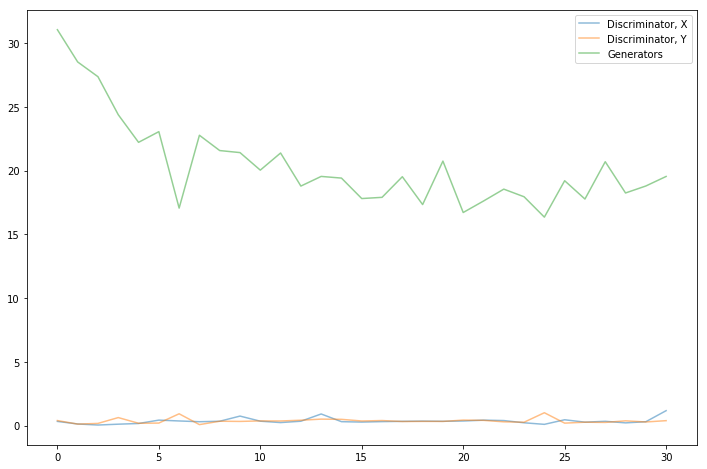

In [57]:
# Training Losses history
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.legend()

## Evaluate

In [ ]:
# samples for inspecting model's performance.
fixed_X = scale(next(iter(test_dataloader_X))[0])
fixed_Y = scale(next(iter(test_dataloader_Y))[0])
fake_X = G_YX(fixed_Y.to(device))
fake_Y = G_XY(fixed_X.to(device))

def to_data(x):
    x = x.cpu().data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8)
    return x

X, fake_X = to_data(fixed_X), to_data(fake_X)
Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)

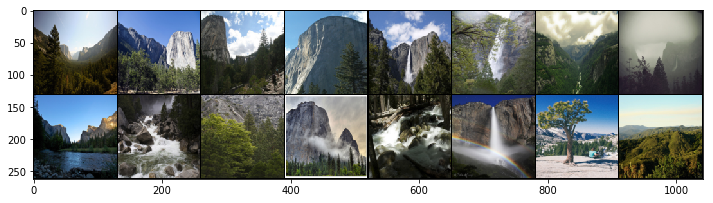

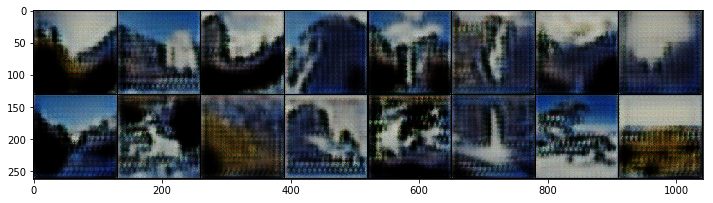

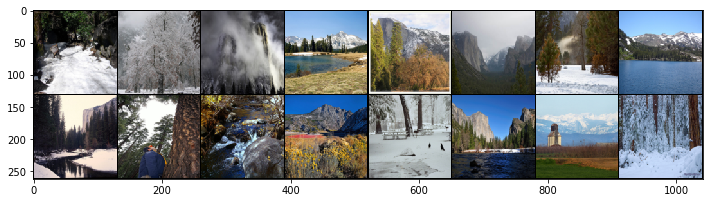

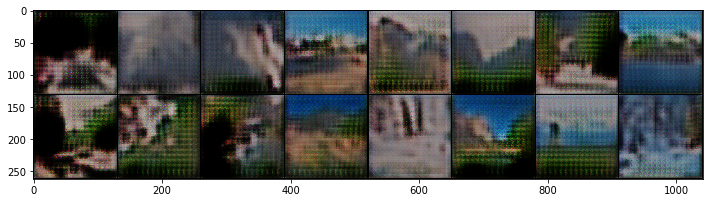

In [60]:
# samples
for loader, G in zip([test_dataloader_X,test_dataloader_Y],
                     [G_XY,G_YX]):
    images, _ = next(iter(loader))
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(np.transpose(torchvision.utils.make_grid(images),(1,2,0)))
    
    fig = plt.figure(figsize=(12, 8))
    fake = G(scale(images).to(device))
    fake = ((fake.cpu().detach()+1)/2)
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake),(1,2,0)))